In [75]:
library(tidyverse)
library(cansim)
library(readr)
library(vroom)
library(lubridate)
library(tseries)
library(strucchange)
library(purrr) 
library(vars)
library(fredr)

# Load libraries
library(tidyverse)
library(strucchange)
library(lubridate)

In [76]:
cpi_vec <- get_cansim_vector_for_latest_periods("v41690973", periods = 300, refresh = TRUE) # CHANGE IN CPI

Accessing CANSIM NDM vectors from Statistics Canada



In [77]:
cpi_monthly <- cpi_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = Date) |>
  dplyr::arrange(month) |> # Good practice to sort by date before lagging
  dplyr::mutate(delta_cpi = (VALUE / dplyr::lag(VALUE, 12) - 1)*100)|>
  dplyr::select(month, delta_cpi) |>
  tidyr::drop_na()

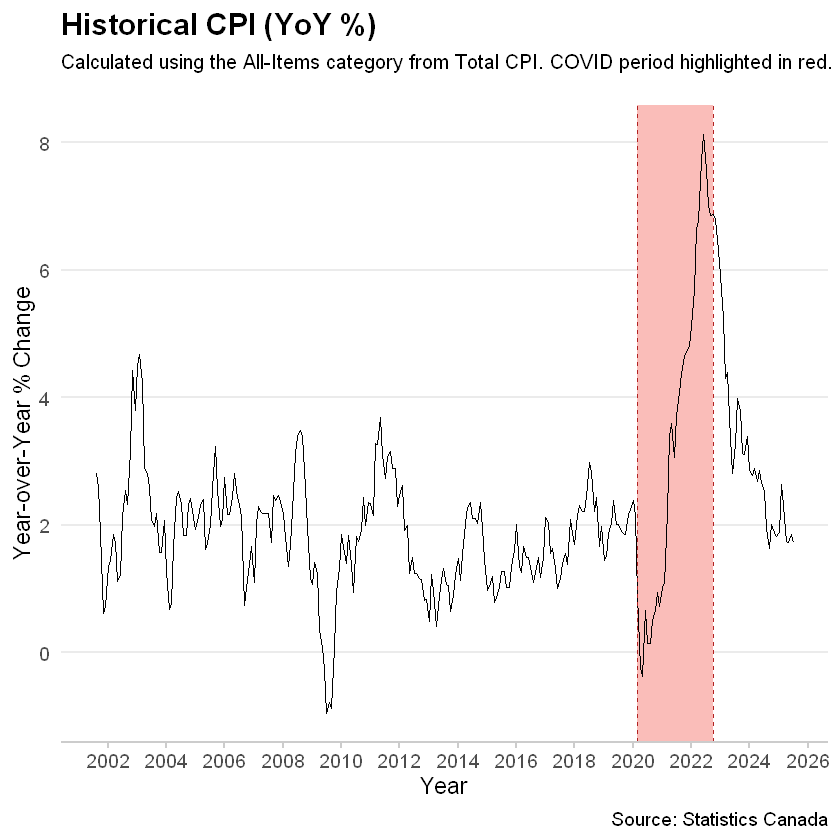

In [78]:
# Load necessary libraries (strucchange is no longer needed for this plot)
library(tidyverse)
library(lubridate)

# --- 1. Manually define the start and end dates for the COVID period ---
covid_start_date <- as.Date("2020-03-01")
covid_end_date   <- as.Date("2022-10-01")


# --- 2. Create the Plot ---

ggplot(cpi_monthly, aes(x = month)) +
  # Add the shaded red rectangle for the COVID period
  geom_rect(aes(xmin = covid_start_date, xmax = covid_end_date, ymin = -Inf, ymax = Inf),
            fill = "#fabdb9",
            alpha = 0.9, color=NA) + 
            
  # Plot the historical data line
  geom_line(aes(y = delta_cpi), color = "black", linewidth = 0.5, na.rm = TRUE) +
  
  # Add vertical dashed lines for the start and end of the period
  geom_vline(xintercept = as.numeric(covid_start_date), 
             linetype = "dashed", 
             color = "firebrick") +
  geom_vline(xintercept = as.numeric(covid_end_date), 
             linetype = "dashed", 
             color = "firebrick") +
             
  # Apply labels and titles
  labs(
    title = "Historical CPI (YoY %)",
    subtitle = "Calculated using the All-Items category from Total CPI. COVID period highlighted in red.",
    x = "Year",
    y = "Year-over-Year % Change",
    caption = "Source: Statistics Canada"
  ) +
  
  # Customize the x-axis date format
  scale_x_date(
    date_breaks = "2 years", 
    date_labels = "%Y"
  ) +
  
  # Apply the same clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80")
  )

In [79]:
last_row <- tail(cpi_monthly, n = 1)
print(last_row)

# A tibble: 1 × 2
  month      delta_cpi
  <date>         <dbl>
1 2025-07-01      1.73


In [80]:
ggsave(
  "cpi_plot_covid.png", # The filename for the saved plot               # The plot object to save
  width = 25,              # Width in inches
  height = 10,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [81]:
start_date <- "2000-01-01"


unemp_vec <- get_cansim_vector_for_latest_periods('v2062815', periods = 500, refresh = TRUE) # UNEMPLOYMENT RATE
gdp_vec <- get_cansim_vector_for_latest_periods("v65201210", periods = 300, refresh = TRUE)

gdp_monthly <- gdp_vec |>
  dplyr::select(Date, VALUE) |>
  # Create a 'month' column and filter
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Calculate month-over-month percent change
  dplyr::mutate(
    delta_gdp = (log(VALUE) - log(dplyr::lag(VALUE, 1))) * 100
  ) |>
  dplyr::select(month, delta_gdp) |>
  tidyr::drop_na()

unemp_monthly <- unemp_vec |>
  dplyr::select(Date, VALUE) |>
  dplyr::mutate(month = lubridate::floor_date(Date, "month")) |>
  dplyr::filter(month >= start_date) |>
  # Using the unemployment rate level directly
  dplyr::mutate(
    delta_unemp = VALUE
  ) |>
  dplyr::select(month, delta_unemp) |>
  tidyr::drop_na()

Accessing CANSIM NDM vectors from Statistics Canada

Accessing CANSIM NDM vectors from Statistics Canada



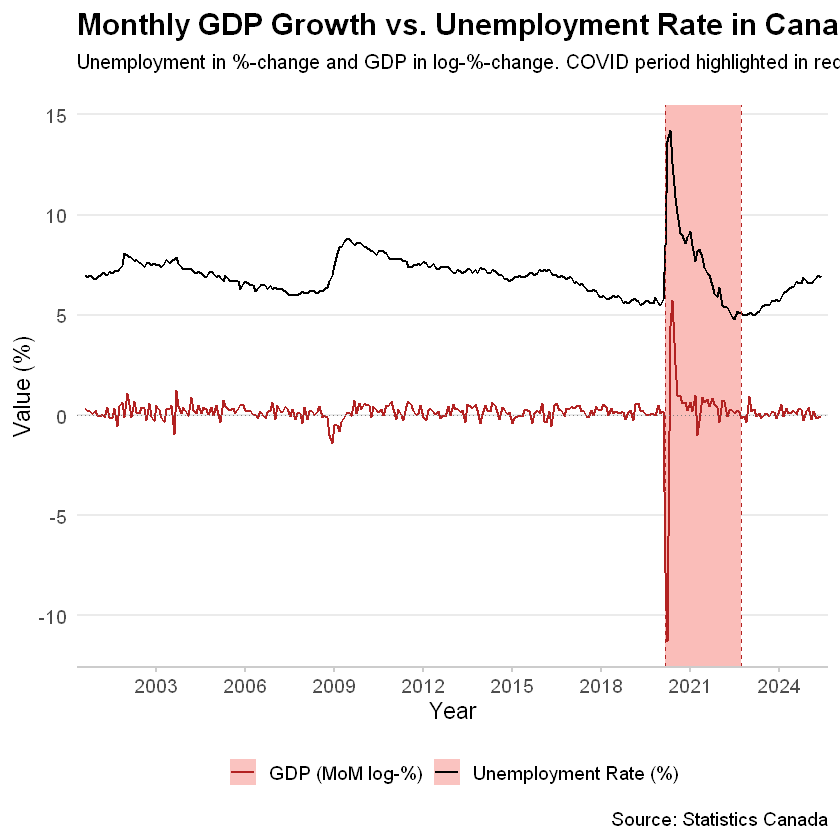

In [113]:
# Load libraries if you haven't already
library(tidyverse)
library(lubridate)

# --- 1. Combine the two data frames ---
# Join the two datasets by their common 'month' column
combined_data <- inner_join(gdp_monthly, unemp_monthly, by = "month")

# --- 2. Reshape the data from 'wide' to 'long' format for ggplot ---
# This is the standard "tidy" approach for plotting multiple series
combined_long <- combined_data %>%
  pivot_longer(
    cols = c(delta_gdp, delta_unemp), 
    names_to = "series", 
    values_to = "value"
  )

# --- 3. Create the Plot ---
ggplot(combined_long, aes(x = month, y = value, color = series, linetype = series)) +

  geom_rect(aes(xmin = covid_start_date, xmax = covid_end_date, ymin = -Inf, ymax = Inf),
            fill = "#fabdb9",
            alpha = 0.9, color=NA) + 
            
  
  # Plot the historical data lines
  geom_line(linewidth = 0.8, na.rm = TRUE) +

    # Add vertical dashed lines for the start and end of the period
  geom_vline(xintercept = as.numeric(covid_start_date), 
             linetype = "dashed", 
             color = "firebrick") +
  geom_vline(xintercept = as.numeric(covid_end_date), 
             linetype = "dashed", 
             color = "firebrick") +

  
  # --- 4. Manually set the colors and line types for each series ---
  scale_color_manual(
    name = "Series", # Legend title
    labels = c(delta_gdp = "GDP (MoM log-%)", delta_unemp = "Unemployment Rate (%)"),
    values = c(delta_gdp = "firebrick", delta_unemp = "black")
  ) +
  scale_linetype_manual(
    name = "Series", # Legend title
    labels = c(delta_gdp = "GDP (MoM log-%)", delta_unemp = "Unemployment Rate (%)"),
    values = c(delta_gdp = "solid", delta_unemp = "solid") # "solid" is a straight line
  ) +
  
  # 5. Add a horizontal line at y=0 for reference
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  # 6. Apply labels and titles
  labs(
    title = "Monthly GDP Growth vs. Unemployment Rate in Canada",
    subtitle = "Unemployment in %-change and GDP in log-%-change. COVID period highlighted in red.",
    x = "Year",
    y = "Value (%)",
    caption = "Source: Statistics Canada"
  ) +
  
  # 7. Customize the x-axis date format
  scale_x_date(
    date_breaks = "3 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01) # Reduce padding at the ends
  ) +
  
  # 8. Apply the same clean theme as your other plots
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "bottom", # Move legend to the bottom
    legend.title = element_blank() # Hide the legend title
  )

In [115]:
ggsave(
  "gdp_v_unemp_covid.png", # The filename for the saved plot               # The plot object to save
  width = 10,              # Width in inches
  height = 5,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [84]:
monthly_real_return_bond <- get_cansim_vector_for_latest_periods('v122553',periods = 500)
monthly_convetional_bond <- get_cansim_vector_for_latest_periods('v122543',periods = 500)
monthly_real_return_bond <- monthly_real_return_bond|>
dplyr::select(Date, VALUE)

monthly_convetional_bond <- monthly_convetional_bond|>
dplyr::select(Date, VALUE)

break_even_df <- monthly_convetional_bond |>
  inner_join(monthly_real_return_bond, by = "Date", suffix = c("_conventional", "_real_return")) |>
  mutate(break_even_inflation_rate = VALUE_conventional - VALUE_real_return) |>
  dplyr::select(Date, break_even_inflation_rate)

Reading CANSIM NDM vectors from temporary cache

Reading CANSIM NDM vectors from temporary cache



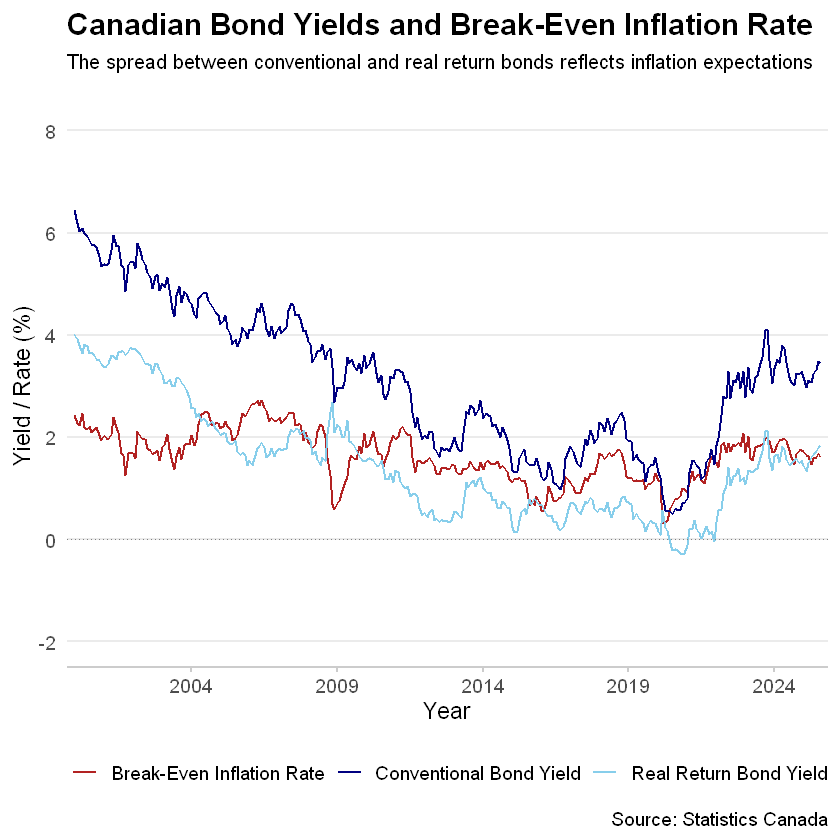

In [116]:
# Load libraries if you haven't already
library(tidyverse)
library(lubridate)

# --- 1. Combine all three data frames for plotting ---
# Rename the VALUE columns before joining for clarity
conventional_renamed <- monthly_convetional_bond %>% 
  rename(conventional_yield = VALUE)
real_return_renamed <- monthly_real_return_bond %>% 
  rename(real_return_yield = VALUE)

# Join all three series into one data frame
combined_bonds <- break_even_df %>%
  inner_join(conventional_renamed, by = "Date") %>%
  inner_join(real_return_renamed, by = "Date")

# --- 2. Reshape the data from 'wide' to 'long' format ---
bonds_long <- combined_bonds %>%
  pivot_longer(
    cols = -Date, # Pivot all columns except for the Date column
    names_to = "series",
    values_to = "value"
  )

# --- 3. Create the Plot ---
ggplot(bonds_long, aes(x = Date, y = value, color = series)) +
  
  # Plot the historical data lines
  geom_line(linewidth = 0.8, na.rm = TRUE) +
  
  # --- 4. Manually set the colors and labels for each series ---
  scale_color_manual(
    name = "Series", # Legend title
    labels = c(
      break_even_inflation_rate = "Break-Even Inflation Rate", 
      conventional_yield = "Conventional Bond Yield", 
      real_return_yield = "Real Return Bond Yield"
    ),
    values = c(
      break_even_inflation_rate = "firebrick", 
      conventional_yield = "navy", 
      real_return_yield = "skyblue"
    )
  ) +
  
  # 5. Add a horizontal line at y=0 for reference
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  # 6. Apply labels and titles
  labs(
    title = "Canadian Bond Yields and Break-Even Inflation Rate",
    subtitle = "The spread between conventional and real return bonds reflects inflation expectations",
    x = "Year",
    y = "Yield / Rate (%)",
    caption = "Source: Statistics Canada"
  ) +
  
  # 7. Customize the x-axis date format
  # 7. Customize the x-axis date format and set limits
  scale_x_date(
    date_breaks = "5 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01),
    limits = c(as.Date("2000-01-01"), NA) # Add this line
  ) +

  # Add this layer to control the y-axis
  scale_y_continuous(
    limits = c(-2, 8),  # Set the lower and upper bounds of the axis
    breaks = seq(-2, 8, by = 2) # Create tick marks every 2 points from -2 to 8
  ) +
  # 8. Apply the same clean theme
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "bottom",
    legend.title = element_blank()
  )

In [117]:
ggsave(
  "break_even.png", # The filename for the saved plot               # The plot object to save
  width = 10,              # Width in inches
  height = 5,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)

In [87]:
all_tarrif_data <- read_csv("C:/Users/Irene/governorschallenge/DataWeb-Query-ExportNew.csv")

Calculated_Duties <- all_tarrif_data|>
filter(Data_Type == "Calculated Duties")|>
dplyr::select(Year, Month, Calculated_Duties)|>
rename(VALUE = Calculated_Duties)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()

general_customs_value <- all_tarrif_data|>
filter(Data_Type == "Customs Value")|>
dplyr::select(Year, Month, Calculated_Duties)|>
rename(VALUE = Calculated_Duties)|>
mutate(
    Date = ymd(paste(Year, Month, "01", sep = "-")),
    VALUE = as.numeric(VALUE)
  ) |>
  dplyr::select(Date, VALUE)|>
  arrange(Date)|>
  glimpse()



tarrif_rate_df <- inner_join(
  Calculated_Duties , 
  general_customs_value, 
  by = "Date",
  suffix = c("_duties", "_value")
) |>
  
  # 2. Calculate the approximate tariff rate using the two VALUE columns
  mutate(
    Approximate_Rate = (VALUE_duties / VALUE_value) * 100
  ) |>
  rename(month = Date)|>
  # 3. Keep only the columns you need for your VAR model
  dplyr::select(month, Approximate_Rate)

Rows: 589 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Data_Type
dbl (2): Year, Month
num (1): Calculated_Duties

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rows: 294
Columns: 2
$ Date  <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-01, 200…
$ VALUE <dbl> 7920740, 6297447, 7184865, 13280139, 4676052, 5389742, 5402475, …
Rows: 294
Columns: 2
$ Date  <date> 2001-01-01, 2001-02-01, 2001-03-01, 2001-04-01, 2001-05-01, 200…
$ VALUE <dbl> 19531777331, 17868333074, 19770282802, 19053810254, 20119959107,…


In [88]:
fredr_set_key('b43b23bac4c602369428a1a4316f23d4')

In [89]:
exc_rate <- fredr(
  series_id = "DEXCAUS",
  observation_start = as.Date("1990-01-01"),
  observation_end = as.Date("2025-08-01"),
  frequency = "m", # monthly
  units = "chg" # change over previous value
)


exc_monthly <- exc_rate |>
rename(month = date)|>
rename(delta_exc = value)|>
dplyr::select(month, delta_exc)|>
tidyr::drop_na()


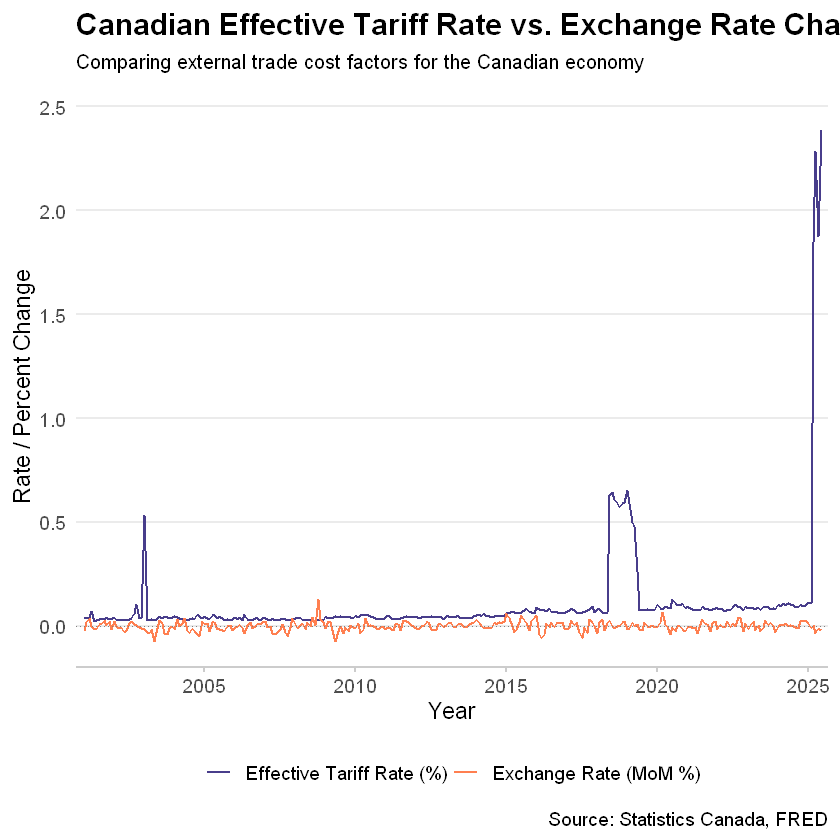

In [90]:
# Load libraries if you haven't already
library(tidyverse)
library(lubridate)

# --- 1. Combine the two data frames ---
# Join the two datasets by their common 'month' column
combined_rates <- inner_join(tarrif_rate_df, exc_monthly, by = "month")

# --- 2. Reshape the data from 'wide' to 'long' format for ggplot ---
rates_long <- combined_rates %>%
  pivot_longer(
    cols = c(Approximate_Rate, delta_exc), 
    names_to = "series", 
    values_to = "value"
  )

# --- 3. Create the Plot ---
ggplot(rates_long, aes(x = month, y = value, color = series)) +
  
  # Plot the historical data lines
  geom_line(linewidth = 0.8, na.rm = TRUE) +
  
  # --- 4. Manually set the colors for each series ---
  scale_color_manual(
    name = "Series", # Legend title
    labels = c(Approximate_Rate = "Effective Tariff Rate (%)", delta_exc = "Exchange Rate (MoM %)"),
    values = c(Approximate_Rate = "darkslateblue", delta_exc = "coral")
  ) +
  
  # 5. Add a horizontal line at y=0 for reference
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  # 6. Apply labels and titles
  labs(
    title = "Canadian Effective Tariff Rate vs. Exchange Rate Change",
    subtitle = "Comparing external trade cost factors for the Canadian economy",
    x = "Year",
    y = "Rate / Percent Change",
    caption = "Source: Statistics Canada, FRED"
  ) +
  
  # 7. Customize the x-axis date format
  scale_x_date(
    date_breaks = "5 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01) # Reduce padding at the ends
  ) +
  
  # 8. Apply the same clean theme as your other plots
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "bottom", # Move legend to the bottom
    legend.title = element_blank() # Hide the legend title
  )

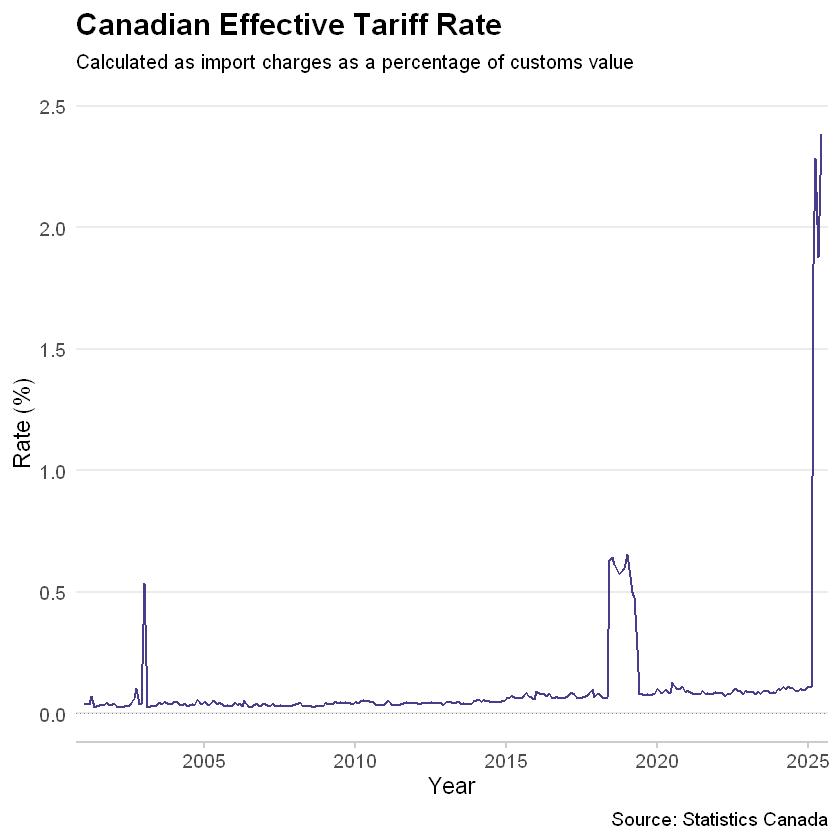

In [94]:
# Load libraries if you haven't already
library(tidyverse)
library(lubridate)

# --- Create the Plot ---
# This code now directly uses your 'tarrif_rate_df' data frame

ggplot(tarrif_rate_df, aes(x = month, y = Approximate_Rate)) +
  
  # Plot the historical data line with the color set directly
  geom_line(color = "darkslateblue", linewidth = 0.8, na.rm = TRUE) +
  
  # Add a horizontal line at y=0 for reference
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  # Apply updated labels and titles for a single series
  labs(
    title = "Canadian Effective Tariff Rate",
    subtitle = "Calculated as import charges as a percentage of customs value",
    x = "Year",
    y = "Rate (%)",
    caption = "Source: Statistics Canada"
  ) +
  
  # Customize the x-axis date format
  scale_x_date(
    date_breaks = "5 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01) # Reduce padding at the ends
  ) +
  
  # Apply the same clean theme as your other plots
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "none" # Remove the legend as it's no longer needed
  )

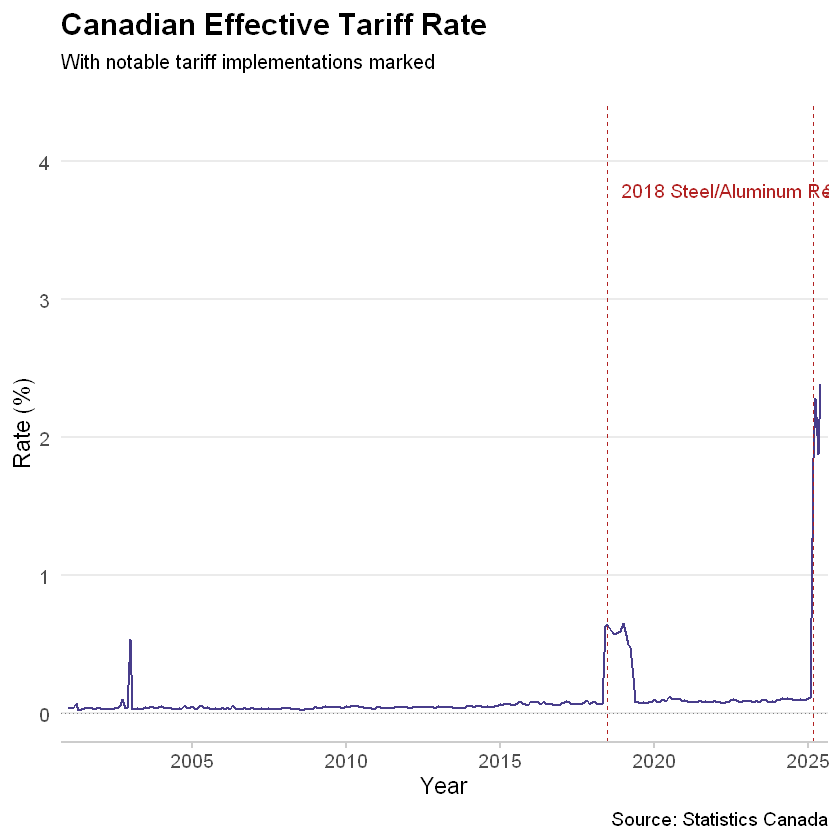

In [99]:
library(tidyverse)
library(lubridate)

# --- 1. Create a data frame for the events to annotate ---
events_df <- tibble(
  date = as.Date(c("2018-07-01", "2025-03-04")),
  label = c(
    "2018 Steel/Aluminum Retaliation",
    "2025 U.S./Canada Tariffs"
  )
)

# --- 2. Create the Plot using your exact code and adding the event layers ---
# This code uses your 'tarrif_rate_df' data frame
ggplot(tarrif_rate_df, aes(x = month, y = Approximate_Rate)) +
  
  # Your original plot layers
  geom_line(color = "darkslateblue", linewidth = 0.8, na.rm = TRUE) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  # --- ADDED THESE LAYERS FOR THE RED LINES AND TEXT ---
  geom_vline(
    data = events_df,
    aes(xintercept = date),
    color = "firebrick",
    linetype = "dashed"
  ) +
  geom_text(
    data = events_df,
    aes(x = date, label = label),
    y = 3.8,          # Y-position for the labels
    hjust = -0.05,      # Nudge text to the right of the line
    color = "firebrick",
    size = 4
  ) +
  # --------------------------------------------------------
  
  # Your original labs and theme
  labs(
    title = "Canadian Effective Tariff Rate",
    subtitle = "With notable tariff implementations marked",
    x = "Year",
    y = "Rate (%)",
    caption = "Source: Statistics Canada"
  ) +
  
  scale_x_date(
    date_breaks = "5 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01)
  ) +
  
  # Added a y-axis limit to make space for the labels
  scale_y_continuous(limits = c(NA, 4.2)) +
  
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "none"
  )

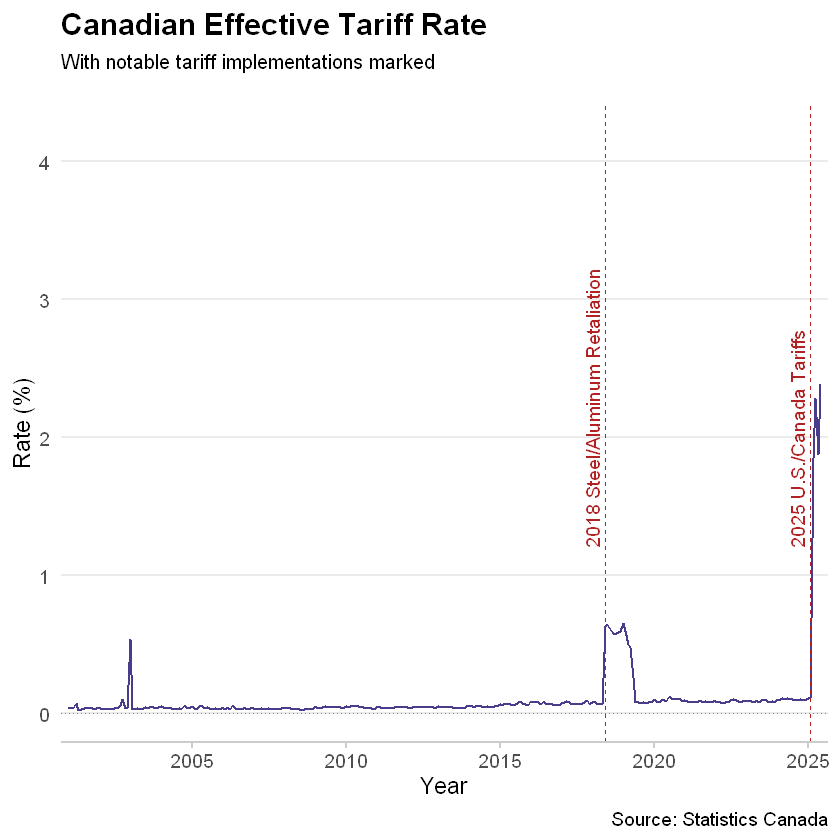

In [ ]:
library(tidyverse)
library(lubridate)

# --- 1. Create a data frame for the events to annotate ---
events_df <- tibble(
  date = as.Date(c("2018-06-01", "2025-02-04")),
  label = c(
    "2018 Steel/Aluminum Retaliation",
    "2025 U.S./Canada Tariffs"
  )
)

# --- 2. Create the Plot with Vertical Annotations ---
# This code uses your 'tarrif_rate_df' data frame
ggplot(tarrif_rate_df, aes(x = month, y = Approximate_Rate)) +
  
  # Your original plot layers
  geom_line(color = "black", linewidth = 0.8, na.rm = TRUE) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  # --- ADDED THESE LAYERS FOR THE RED LINES AND TEXT ---
  geom_vline(
    data = events_df,
    aes(xintercept = date),
    color = "firebrick",
    linetype = "dashed"
  ) +
  # Text layer is now modified for vertical alignment
  geom_text(
    data = events_df,
    aes(x = date, label = label),
    y = 1.2,          # Sets the y-position for the bottom of the text
    angle = 90,       # Rotates the text 90 degrees
    hjust = 0,        # Aligns the bottom of the text to the y-position
    vjust = -0.4,     # Nudges the text to the right of the line
    color = "firebrick",
    size = 4
  ) +
  # --------------------------------------------------------
  
  # Your original labs and theme
  labs(
    title = "Canadian Effective Tariff Rate",
    subtitle = "With notable tariff implementations marked",
    x = "Year",
    y = "Rate (%)",
    caption = "Source: Statistics Canada"
  ) +
  
  scale_x_date(
    date_breaks = "5 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01)
  ) +
  
  scale_y_continuous(limits = c(NA, 4.2)) +
  
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "none"
  )

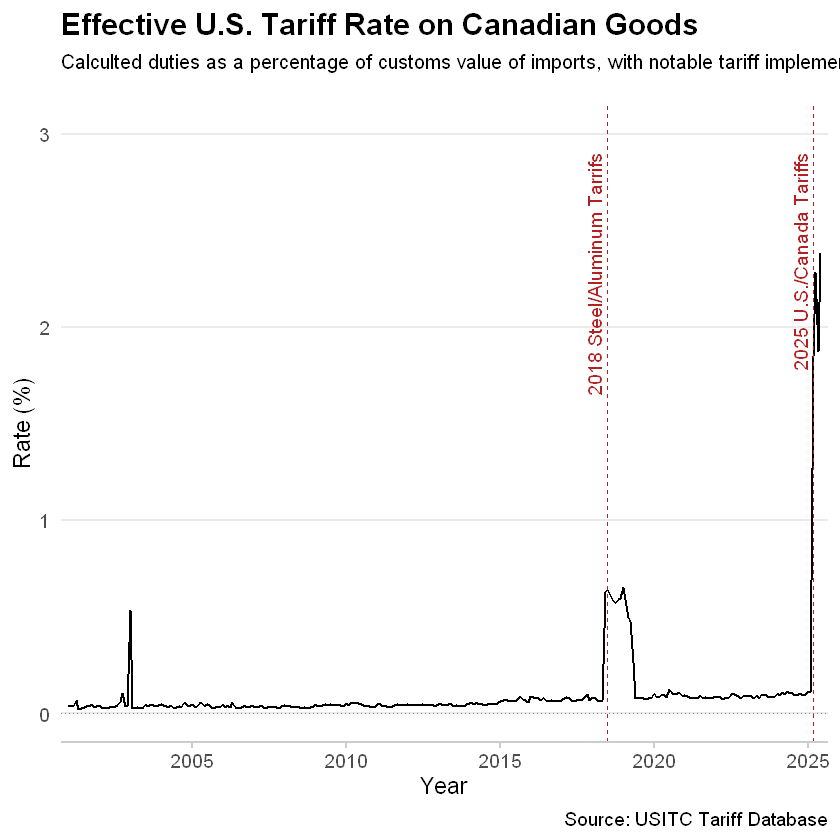

In [109]:
library(tidyverse)
library(lubridate)

# --- 1. Create a data frame for the events to annotate ---
events_df <- tibble(
  date = as.Date(c("2018-07-01", "2025-03-04")),
  label = c(
    "2018 Steel/Aluminum Tarrifs",
    "2025 U.S./Canada Tariffs"
  )
)

# --- 2. Create the Final Plot ---
# This code uses your 'tarrif_rate_df' data frame
ggplot(tarrif_rate_df, aes(x = month, y = Approximate_Rate)) +
  
  geom_line(color = "black", linewidth = 0.8, na.rm = TRUE) +
  geom_hline(yintercept = 0, linetype = "dotted", color = "grey50") +
  
  geom_vline(
    data = events_df,
    aes(xintercept = date),
    color = "firebrick",
    linetype = "dashed"
  ) +
  
  # Text layer is now modified to fit within the new axis limits
  geom_text(
    data = events_df,
    aes(x = date, label = label),
    y = 2.9,          # Sets the y-position for the TOP of the text
    angle = 90,       # Rotates the text 90 degrees
    hjust = 1,        # Aligns the TOP of the text to the y-position
    vjust = -0.4,     # Nudges the text to the right of the line
    color = "firebrick",
    size = 4
  ) +
  
  labs(
    title = "Effective U.S. Tariff Rate on Canadian Goods",
    subtitle = "Calculted duties as a percentage of customs value of imports, with notable tariff implementations marked",
    x = "Year",
    y = "Rate (%)",
    caption = "Source: USITC Tariff Database"
  ) +
  
  scale_x_date(
    date_breaks = "5 years", 
    date_labels = "%Y",
    expand = c(0.01, 0.01)
  ) +
  
  # Set the final y-axis scale
  scale_y_continuous(
    limits = c(NA, 3), # Set upper limit to 3
    breaks = seq(0, 3, by = 1) # Create clean breaks from 0 to 3
  ) +
  
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    plot.subtitle = element_text(size = 12, margin = margin(b = 20)),
    panel.grid.minor = element_blank(),
    panel.grid.major.x = element_blank(),
    axis.line.x = element_line(color="grey80"),
    axis.ticks.x = element_line(color="grey80"),
    legend.position = "none"
  )

In [110]:
ggsave(
  "tarrif_rate.png", # The filename for the saved plot               # The plot object to save
  width = 17,              # Width in inches
  height = 6,              # Height in inches
  dpi = 300                # Dots per inch (resolution)
)